# Final Project

## Henrique Melo

### Store Item Demand Forecasting Challenge

The challenge is to predict 3 months of sales data, from 10 different stores and 50 different products, using 4 years and 9 months of data. The error is calculated as SMAPE.

Link to data: https://www.kaggle.com/c/demand-forecasting-kernels-only

The project is divided into the follwing phases:
<br> 
1) Research
<br>
2) Data Preparation
<br>
3) Modelling/Analysis
<br>
4) Visualization



In [70]:
# Used packages for analysis

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [71]:
# Auxiliar function to calculate error and evaluate analysis

def calculate_error(true, predicted):
    num = abs(predicted - true)
    den = (abs(predicted) + abs(true))/2
    smape = sum(num/den) * 100 / len(true)
    text = "The SMAPE error percentage is " + str(round(smape, 2)) + "%"
    return smape, text

# 1) Research Phase

The first step is to Import the Dataset and take a look at it:

In [72]:
# Read csv file
MyData = pd.read_csv("train.csv", index_col=0, parse_dates=True)

#Divide data into trainning data and test data
TrainData = MyData.loc[:"2017-09-30",:]
TestData = MyData.loc["2017-10-01":,:]

TrainData.head(8)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9


In [73]:
TrainData.tail(8)

,store,item,sales
date,,,
2017-09-23,10,50,97
2017-09-24,10,50,99
2017-09-25,10,50,63
2017-09-26,10,50,79
2017-09-27,10,50,80
2017-09-28,10,50,82
2017-09-29,10,50,90
2017-09-30,10,50,103


In [74]:
TestData.head(8)

,store,item,sales
date,,,
2017-10-01,1,1,21
2017-10-02,1,1,12
2017-10-03,1,1,18
2017-10-04,1,1,15
2017-10-05,1,1,20
2017-10-06,1,1,19
2017-10-07,1,1,22
2017-10-08,1,1,19


Text(0.5,1,'Average Sales per Store')

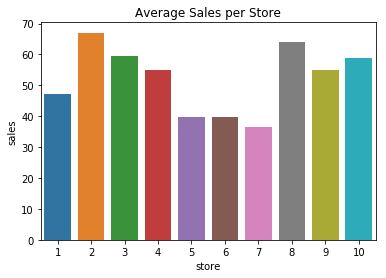

In [75]:
group1 = MyData.groupby(["store"]).mean()
#sns.barplot(x = group1.index, y = group1.sales)
sns.barplot(x = group1.index, y = group1.sales).set_title("Average Sales per Store")

Text(0.5,1,'Average Sales per Item')

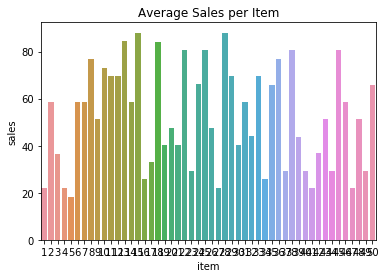

In [76]:
group2 = MyData.groupby(["item"]).mean()
sns.barplot(x = group2.index, y = group2.sales).set_title("Average Sales per Item")

C:\Users\hsabo\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


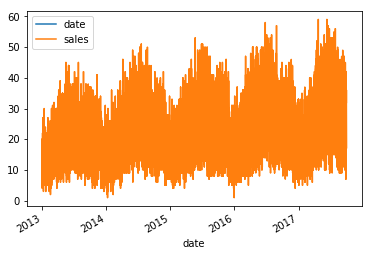

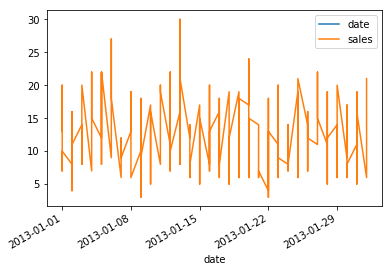

In [77]:
ID1 = TrainData[TrainData.item == 1]
ID1.loc[:, ["date", "sales"]].plot()
ID1.loc["2013-01-01":"2013-02-01", ["date", "sales"]].plot()

# 2) Data Preparation

In [78]:
# Turn Trainning set dates into ordinal numbers for OLS

a = pd.Series(TrainData.index, index = TrainData.index).apply(lambda x: x.toordinal())
a = a - min(a)
a = a.drop_duplicates(keep = "first")
a = pd.DataFrame(a)
a.columns = ["datevalue"]
len(a)

1734

In [79]:
# Turn Test set dates into ordinal numbers for OLS

b = pd.Series(TestData.index, index = TestData.index).apply(lambda x: x.toordinal())
b = b - min(b)
b = b + max(a.datevalue) + 1
b = b.drop_duplicates(keep = "first")
b = pd.DataFrame(b)
b.columns = ["datevalue"]
len(b)

92

In [80]:
a.tail()

,datevalue
date,
2017-09-26,1729
2017-09-27,1730
2017-09-28,1731
2017-09-29,1732
2017-09-30,1733


In [81]:
b.head()

,datevalue
date,
2017-10-01,1734
2017-10-02,1735
2017-10-03,1736
2017-10-04,1737
2017-10-05,1738


In [82]:
#Merge original table with ordial values

TD2 = TrainData.copy()
TE2 = TestData.copy()

TD2 = TD2.merge(a, right_index=True, left_index=True)
TE2 = TE2.merge(b, right_index=True, left_index=True)

In [83]:
TD2.head(12)

,store,item,sales,datevalue
date,,,,
2013-01-01,1,1,13,0
2013-01-01,2,1,12,0
2013-01-01,3,1,19,0
2013-01-01,4,1,10,0
2013-01-01,5,1,11,0
2013-01-01,6,1,20,0
2013-01-01,7,1,7,0
2013-01-01,8,1,16,0
2013-01-01,9,1,11,0


In [84]:
TE2.head(12)

,store,item,sales,datevalue
date,,,,
2017-10-01,1,1,21,1734
2017-10-01,2,1,42,1734
2017-10-01,3,1,42,1734
2017-10-01,4,1,32,1734
2017-10-01,5,1,17,1734
2017-10-01,6,1,21,1734
2017-10-01,7,1,23,1734
2017-10-01,8,1,40,1734
2017-10-01,9,1,28,1734


In [85]:
TD2["item"] = TD2["item"].astype("category")
TD2["store"] = TD2["store"].astype("category")

TE2["item"] = TE2["item"].astype("category")
TE2["store"] = TE2["store"].astype("category")

# 3) Modelling Analysis

## First model: simple regression over aggregated data

In [86]:
# Regression Model using only date, item and store

model_1 = smf.ols(data = TD2, formula = "sales ~ datevalue + item + store")

result_1 = model_1.fit()

In [87]:
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                 3.691e+04
Date:                Mon, 26 Nov 2018   Prob (F-statistic):               0.00
Time:                        16:43:05   Log-Likelihood:            -3.5995e+06
No. Observations:              867000   AIC:                         7.199e+06
Df Residuals:                  866940   BIC:                         7.200e+06
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5075      0.130     50.051      0.000       6.253       6.762
item[T.2]      36.5106      0.165    221.104      0.000      36.187      36.834
item[T.3]      14.6079      0.165     88.464      0.000      14.284      14.932
item[T.4]       0.0286      0.165      0.173      0.862      -0.295       0.352
item[T.5]      -3.6229      0.165    -21.940      0.000      -3.947      -3.299
item[T.6]      36.4446      0.165    220.704      0.000      36.121      36.768
item[T.7]      36.4556      0.165    220.771      0.000      36.132      36.779
item[T.8]      54.8046      0.165    331.890      0.000      54.481      55.128
item[T.9]      29.3615      0.165    177.810      0.000      29.038      29.685
item[T.10]     51.1067      0.165    309.496      0.000      50.783      51.430
item[T.11]     47.5085      0.165    287.706      0.000      47.185      47.832
item[T.12]     47.5400      0.165    287.897      0.000      47.216      47.864
item[T.13]     62.1903      0.165    376.617      0.000      61.867      62.514
item[T.14]     36.5878      0.165    221.572      0.000      36.264      36.911
item[T.15]     65.8734      0.165    398.921      0.000      65.550      66.197
item[T.16]      3.6753      0.165     22.257      0.000       3.352       3.999
item[T.17]     10.9964      0.165     66.593      0.000      10.673      11.320
item[T.18]     62.1405      0.165    376.315      0.000      61.817      62.464
item[T.19]     18.3308      0.165    111.009      0.000      18.007      18.654
item[T.20]     25.4657      0.165    154.218      0.000      25.142      25.789
item[T.21]     18.2876      0.165    110.748      0.000      17.964      18.611
item[T.22]     58.3719      0.165    353.493      0.000      58.048      58.696
item[T.23]      7.2867      0.165     44.128      0.000       6.963       7.610
item[T.24]     43.9546      0.165    266.184      0.000      43.631      44.278
item[T.25]     58.5685      0.165    354.684      0.000      58.245      58.892
item[T.26]     25.6007      0.165    155.035      0.000      25.277      25.924
item[T.27]      0.0796      0.165      0.482      0.630      -0.244       0.403
item[T.28]     65.7250      0.165    398.023      0.000      65.401      66.049
item[T.29]     47.5217      0.165    287.786      0.000      47.198      47.845
item[T.30]     18.3263      0.165    110.982      0.000      18.003      18.650
item[T.31]     36.5745      0.165    221.491      0.000      36.251      36.898
item[T.32]     21.9264      0.165    132.784      0.000      21.603      22.250
item[T.33]     47.4829      0.165    287.551      0.000      47.159      47.807
item[T.34]      3.7349      0.165     22.618      0.000       3.411       4.059
item[T.35]     43.7145      0.165    264.730      0.000      43.391      44.038
item[T.36]     54.8906      0.165    332.41

In [88]:
TD2["predicted"] = result_1.predict(TD2)

TD2.head()

,store,item,sales,datevalue,predicted
date,,,,,
2013-01-01,1,1,13,0,6.507513
2013-01-01,2,1,12,0,26.222749
2013-01-01,3,1,19,0,18.747052
2013-01-01,4,1,10,0,14.132323
2013-01-01,5,1,11,0,-0.961633


In [89]:
error_1, text_1 = calculate_error(TD2["sales"], TD2["predicted"])
text_1 + " for the TRAIN Data"

'The SMAPE error percentage is 26.88% for the TRAIN Data'

In [90]:
TE2["predicted"] = result_1.predict(TE2)

TE2.head()

,store,item,sales,datevalue,predicted
date,,,,,
2017-10-01,1,1,21,1734,27.416575
2017-10-01,2,1,42,1734,47.131812
2017-10-01,3,1,42,1734,39.656114
2017-10-01,4,1,32,1734,35.041385
2017-10-01,5,1,17,1734,19.947429


In [91]:
error_1_test, text_1_test = calculate_error(TE2["sales"], TE2["predicted"])
text_1_test + " for the TEST Data"

'The SMAPE error percentage is 26.34% for the TEST Data'

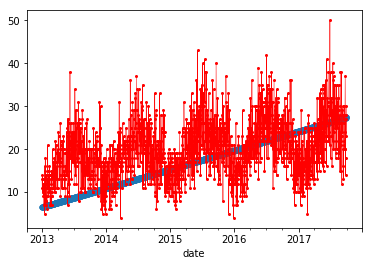

In [92]:
TD2[(TD2["item"] == 1) & (TD2["store"] == 1)].predicted.plot(marker="o", markersize = 5)
TD2[(TD2["item"] == 1) & (TD2["store"] == 1)].sales.plot(marker="o", color = "r", linewidth = 0.5, markersize = 2)

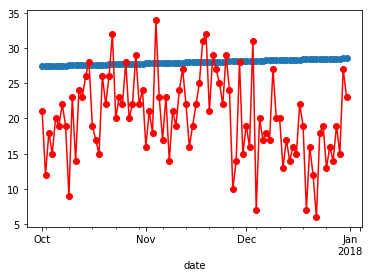

In [93]:
TE2[(TE2["item"] == 1) & (TE2["store"] == 1)].predicted.plot(marker="o")
TE2[(TE2["item"] == 1) & (TE2["store"] == 1)].sales.plot(marker="o", color = "r")

The model is too simple to represent the data!!

## Second model: add more variables to regression on aggregated data

In [94]:
TD3 = TD2.copy()
TE3 = TE2.copy()

In [95]:
TD3["weekday"] = TD3.index.weekday.astype("category")
TE3["weekday"] = TE3.index.weekday.astype("category")

TD3.head()

,store,item,sales,datevalue,predicted,weekday
date,,,,,,
2013-01-01,1,1,13,0,6.507513,1
2013-01-01,2,1,12,0,26.222749,1
2013-01-01,3,1,19,0,18.747052,1
2013-01-01,4,1,10,0,14.132323,1
2013-01-01,5,1,11,0,-0.961633,1


In [96]:
TD3["month"] = TD3.index.month.astype("category")
TE3["month"] = TE3.index.month.astype("category")

TD3.tail()

,store,item,sales,datevalue,predicted,weekday,month
date,,,,,,,
2017-09-30,6,50,66,1733,63.713317,5,9
2017-09-30,7,50,56,1733,60.349673,5,9
2017-09-30,8,50,115,1733,88.048911,5,9
2017-09-30,9,50,86,1733,78.986120,5,9
2017-09-30,10,50,103,1733,82.651610,5,9


In [97]:
model_2 = smf.ols(data = TD3, formula = "sales ~ datevalue + item + store + weekday + month")

result_2 = model_2.fit()

In [98]:
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                 7.550e+04
Date:                Mon, 26 Nov 2018   Prob (F-statistic):               0.00
Time:                        16:43:16   Log-Likelihood:            -3.2637e+06
No. Observations:              867000   AIC:                         6.528e+06
Df Residuals:                  866923   BIC:                         6.529e+06
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -18.3224      0.099   -185.570      0.000     -18.516     -18.129
item[T.2]       36.5106      0.112    325.672      0.000      36.291      36.730
item[T.3]       14.6079      0.112    130.302      0.000      14.388      14.828
item[T.4]        0.0286      0.112      0.255      0.799      -0.191       0.248
item[T.5]       -3.6229      0.112    -32.316      0.000      -3.843      -3.403
item[T.6]       36.4446      0.112    325.084      0.000      36.225      36.664
item[T.7]       36.4556      0.112    325.182      0.000      36.236      36.675
item[T.8]       54.8046      0.112    488.854      0.000      54.585      55.024
item[T.9]       29.3615      0.112    261.902      0.000      29.142      29.581
item[T.10]      51.1067      0.112    455.869      0.000      50.887      51.326
item[T.11]      47.5085      0.112    423.773      0.000      47.289      47.728
item[T.12]      47.5400      0.112    424.054      0.000      47.320      47.760
item[T.13]      62.1903      0.112    554.734      0.000      61.971      62.410
item[T.14]      36.5878      0.112    326.361      0.000      36.368      36.808
item[T.15]      65.8734      0.112    587.586      0.000      65.654      66.093
item[T.16]       3.6753      0.112     32.783      0.000       3.456       3.895
item[T.17]      10.9964      0.112     98.087      0.000      10.777      11.216
item[T.18]      62.1405      0.112    554.289      0.000      61.921      62.360
item[T.19]      18.3308      0.112    163.510      0.000      18.111      18.551
item[T.20]      25.4657      0.112    227.153      0.000      25.246      25.685
item[T.21]      18.2876      0.112    163.124      0.000      18.068      18.507
item[T.22]      58.3719      0.112    520.673      0.000      58.152      58.592
item[T.23]       7.2867      0.112     64.997      0.000       7.067       7.506
item[T.24]      43.9546      0.112    392.072      0.000      43.735      44.174
item[T.25]      58.5685      0.112    522.427      0.000      58.349      58.788
item[T.26]      25.6007      0.112    228.357      0.000      25.381      25.820
item[T.27]       0.0796      0.112      0.710      0.478      -0.140       0.299
item[T.28]      65.7250      0.112    586.263      0.000      65.505      65.945
item[T.29]      47.5217      0.112    423.890      0.000      47.302      47.741
item[T.30]      18.3263      0.112    163.469      0.000      18.107      18.546
item[T.31]      36.5745      0.112    326.242      0.000      36.355      36.794
item[T.32]      21.9264      0.112    195.582      0.000      21.707      22.146
item[T.33]      47.4829      0.112    423.544      0.000      47.263      47.703
item[T.34]       3.7349      0.112     33.315      0.000       3.515       3.955
item[T.35]      43.7145      0.112    389.930      0.000      43.495      43.934
item[

Problems with Colinearity! The Betas may not be real Betas.

In [99]:
TD3["predicted"] = result_2.predict(TD3)


TD3.head()

,store,item,sales,datevalue,predicted,weekday,month
date,,,,,,,
2013-01-01,1,1,13,0,-11.420047,1,1
2013-01-01,2,1,12,0,8.295189,1,1
2013-01-01,3,1,19,0,0.819491,1,1
2013-01-01,4,1,10,0,-3.795238,1,1
2013-01-01,5,1,11,0,-18.889194,1,1


In [100]:
error_2, text_2 = calculate_error(TD3["sales"], TD3["predicted"])
text_2 + " for the TRAIN Data"

'The SMAPE error percentage is 23.02% for the TRAIN Data'

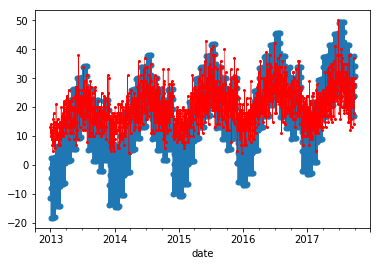

In [101]:
TD3[(TD3["item"] == 1) & (TD3["store"] == 1)].predicted.plot(marker="o", markersize = 5)
TD3[(TD3["item"] == 1) & (TD3["store"] == 1)].sales.plot(marker="o", color = "r", linewidth = 0.5, markersize = 2)

In [102]:
TE3["month"] = pd.Series(TE3["month"], dtype = "category").cat.add_categories([1, 2, 3 , 4, 5, 6, 7, 8, 9])
TE3["month"] = TE3["month"].cat.reorder_categories([1,2,3,4,5,6,7,8,9,10,11,12])
TE3["month"].cat.categories

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [103]:
TE3["predicted"] = result_2.predict(TE3)

TE3.head()

,store,item,sales,datevalue,predicted,weekday,month
date,,,,,,,
2017-10-01,1,1,21,1734,33.622670,6,10
2017-10-01,2,1,42,1734,53.337907,6,10
2017-10-01,3,1,42,1734,45.862209,6,10
2017-10-01,4,1,32,1734,41.247480,6,10
2017-10-01,5,1,17,1734,26.153524,6,10


In [104]:
error_2_test, text_2_test = calculate_error(TE3["sales"], TE3["predicted"])
text_2_test + " for the TEST Data"

'The SMAPE error percentage is 18.35% for the TEST Data'

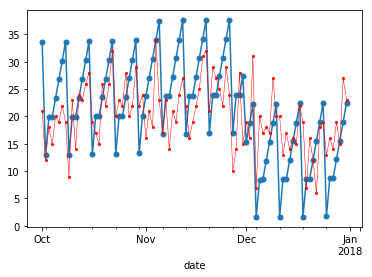

In [105]:
TE3[(TE3["item"] == 1) & (TE3["store"] == 1)].predicted.plot(marker="o", markersize = 5)
TE3[(TE3["item"] == 1) & (TE3["store"] == 1)].sales.plot(marker="o", color = "r", linewidth = 0.5, markersize = 2)

This model represents the data better, however it is still to general, uses too many degrees of freedom and many dummy variables, becoming something close to a sum of averages.

## Third model: separate data

In [106]:
TD4 = TD3.copy()
TE4 = TE3.copy()

In [107]:
TD4 = TD4[(TD4["item"] == 1) & (TD4["store"] == 1)]
TE4 = TE4[(TE4["item"] == 1) & (TE4["store"] == 1)]

In [108]:
model_3 = smf.ols(data = TD4, formula = "sales ~ datevalue + weekday + month")

result_3 = model_3.fit()

In [109]:
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     129.1
Date:                Mon, 26 Nov 2018   Prob (F-statistic):          8.30e-303
Time:                        16:43:19   Log-Likelihood:                -5037.5
No. Observations:                1734   AIC:                         1.011e+04
Df Residuals:                    1715   BIC:                         1.022e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.1878      0.472     13.106      0.000       5.262       7.114
weekday[T.1]     2.6433      0.400      6.615      0.000       1.860       3.427
weekday[T.2]     3.2921      0.400      8.239      0.000       2.508       4.076
weekday[T.3]     3.8948      0.400      9.747      0.000       3.111       4.679
weekday[T.4]     5.6081      0.400     14.035      0.000       4.824       6.392
weekday[T.5]     7.3306      0.400     18.346      0.000       6.547       8.114
weekday[T.6]     8.1699      0.400     20.426      0.000       7.385       8.954
month[T.2]       0.8531      0.517      1.649      0.099      -0.162       1.868
month[T.3]       3.6551      0.505      7.237      0.000       2.664       4.646
month[T.4]       6.7403      0.509     13.230      0.000       5.741       7.740
month[T.5]       8.0655      0.506     15.954      0.000       7.074       9.057
month[T.6]      10.5437      0.510     20.669      0.000       9.543      11.544
month[T.7]      11.5518      0.506     22.811      0.000      10.559      12.545
month[T.8]       7.9594      0.507     15.700      0.000       6.965       8.954
month[T.9]       6.7436      0.512     13.177      0.000       5.740       7.747
month[T.10]      5.1685      0.536      9.645      0.000       4.117       6.220
month[T.11]      6.9063      0.541     12.763      0.000       5.845       7.968
month[T.12]     -0.0863      0.537     -0.161      0.872      -1.139       0.966
datevalue        0.0041      0.000     19.124      0.000       0.004       0.005
==============================================================================
Omnibus:                       24.926   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.281
Skew:                           0.236   Prob(JB):                     7.22e-07
Kurtosis:                       3.411   Cond. No.                     1.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
TD4["predicted"] = result_3.predict(TD4)

TD4.head()

,store,item,sales,datevalue,predicted,weekday,month
date,,,,,,,
2013-01-01,1,1,13,0,8.831112,1,1
2013-01-02,1,1,11,1,9.484083,2,1
2013-01-03,1,1,14,2,10.090882,3,1
2013-01-04,1,1,13,3,11.808263,4,1
2013-01-05,1,1,10,4,13.534889,5,1


In [111]:
error_3, text_3 = calculate_error(TD4["sales"], TD4["predicted"])
text_3 + " for the TRAIN Data"

'The SMAPE error percentage is 18.67% for the TRAIN Data'

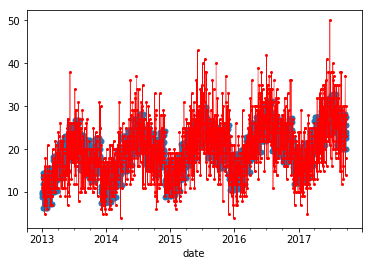

In [112]:
TD4.predicted.plot(marker="o", markersize = 5)
TD4.sales.plot(marker="o", color = "r", linewidth = 0.5, markersize = 2)

In [113]:
TE4["month"] = pd.Series(TE4["month"], dtype = "category").cat.add_categories([1, 2, 3 , 4, 5, 6, 7, 8, 9])
TE4["month"] = TE4["month"].cat.reorder_categories([1,2,3,4,5,6,7,8,9,10,11,12])
TE4["month"].cat.categories

ValueError: new categories must not include old categories: {1, 2, 3, 4, 5, 6, 7, 8, 9}

In [114]:
TE4["predicted"] = result_3.predict(TE4)
TE4.head()

,store,item,sales,datevalue,predicted,weekday,month
date,,,,,,,
2017-10-01,1,1,21,1734,26.668033,6,10
2017-10-02,1,1,12,1735,18.502248,0,10
2017-10-03,1,1,18,1736,21.149664,1,10
2017-10-04,1,1,15,1737,21.802635,2,10
2017-10-05,1,1,20,1738,22.409434,3,10


In [115]:
error_3_test, text_3_test = calculate_error(TE4["sales"], TE4["predicted"])
text_3_test + " for the TEST Data"

'The SMAPE error percentage is 20.6% for the TEST Data'

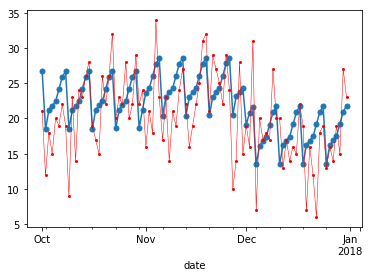

In [116]:
TE4.predicted.plot(marker="o", markersize = 5)
TE4.sales.plot(marker="o", color = "r", linewidth = 0.5, markersize = 2)

Now, if we were to analyze how good are Linear Models to each item:

In [117]:
TrainErrors = []
TestErrors = []

for i in range(1,51):    
    for s in range(1,11):
        TDM = TD3.copy()
        TEM = TE3.copy()

        TDM = TDM[(TDM["item"] == i) & (TDM["store"] == s)]
        TEM = TEM[(TEM["item"] == i) & (TEM["store"] == s)]

        model_M = smf.ols(data = TDM, formula = "sales ~ datevalue + weekday + month").fit()
        TDM["predicted"] = model_M.predict(TDM)

        error_M, text_M = calculate_error(TDM["sales"], TDM["predicted"])
        #print(text_M, " for the store", str(s), "and item", str(i), "for TRAIN set")
        TrainErrors.append(error_M)
        
        #TEM["month"] = pd.Series(TEM["month"], dtype = "category").cat.add_categories([1, 2, 3 , 4, 5, 6, 7, 8, 9])
        #TEM["month"] = TEM["month"].cat.reorder_categories([1,2,3,4,5,6,7,8,9,10,11,12])
        #TEM["month"].cat.categories
        
        TEM["predicted"] = model_M.predict(TEM)
        error_M_test, text_M_test = calculate_error(TEM["sales"], TEM["predicted"])
        #print(text_M_test, " for the store", str(s), "and item", str(i), "for TEST set")
        TestErrors.append(error_M_test)

{'whiskers': [<matplotlib.lines.Line2D at 0x1d580a71080>,
 'caps': [<matplotlib.lines.Line2D at 0x1d580a71940>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d580a69ef0>,
 'medians': [<matplotlib.lines.Line2D at 0x1d580a791d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d580a795f8>,
 'means': []}

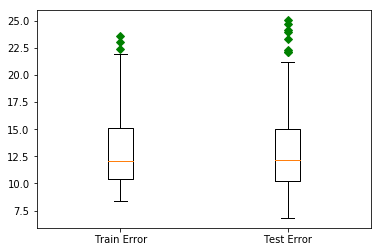

In [118]:
plt.figure()
plt.boxplot([TrainErrors, TestErrors], 0, 'gD', labels = ["Train Error", "Test Error"])

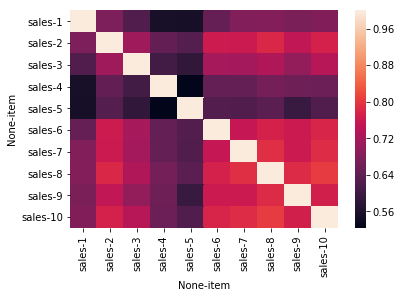

In [242]:
CorDF = TD3.copy()

CorDF = CorDF.loc[:,["sales", "item", "store"]]

CorDF = CorDF[CorDF["store"] == 1].loc[:,["sales", "item"]].pivot(columns = "item")

sns.heatmap(CorDF.corr().iloc[:10,:10])

## Alternative Model: Gradient Boosting

In [174]:
from sklearn.ensemble import GradientBoostingRegressor


TDG = TD3.copy()
TEG = TE3.copy()

x_train = TDG.loc[:, ["store", "item", "datevalue", "weekday", "month"]]
y_train = TDG.loc[:, "sales"]

x_test = TEG.loc[:, ["store", "item", "datevalue", "weekday", "month"]]
y_test = TEG.loc[:, "sales"]

In [177]:
#Cross-Validation
#TDG["k"] = np.random.choice(np.repeat(np.arange(5), len(TDG.index)/5), len(TDG.index), replace=False)

#for k in range(0,5):
#    x_train = TDG.loc[TDG["k"] != k, ["store", "item", "datevalue", "weekday", "month"]]
#    y_train = TDG.loc[TDG["k"] != k, "sales"]

n_est = [100, 200, 300]
lr = [0.2, 0.1, 0.05]

parameters = []
train_error = []
test_error = []

for l in lr:
    for n in n_est:
        model = GradientBoostingRegressor(n_estimators = n,
                                         learning_rate = l)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        TDG["predicted"] = y_pred
        TEG["predicted"] = test_pred

        error_G, text_G = calculate_error(TDG["sales"], TDG["predicted"])
        text_G + " for the TRAIN Data"

        error_Te, text_Te = calculate_error(TEG["sales"], TEG["predicted"])
        text_Te + " for the TEST Data"

        train_error.append(error_G)
        test_error.append(error_Te)
        parameters.append([n_est, lr])
    

In [204]:
GBresutls = pd.DataFrame([train_error, test_error, list(np.tile([100,200,300], 3)), list(np.repeat([0.2, 0.1, 0.05], 3))])
GBresutls

,0,1,2,3,4,5,6,7,8
0,19.919583,19.196163,18.578882,25.652053,20.127389,19.449322,32.201592,25.249212,21.308091
1,19.829647,17.945154,17.706175,26.803175,19.740467,18.215828,32.807685,26.194143,21.550625
2,100.000000,200.000000,300.000000,100.000000,200.000000,300.000000,100.000000,200.000000,300.000000
3,0.200000,0.200000,0.200000,0.100000,0.100000,0.100000,0.050000,0.050000,0.050000


In [208]:
model = GradientBoostingRegressor(n_estimators = 300,
                                 learning_rate = 0.2)
model.fit(x_train, y_train)

y_pred = model.predict(x_train)
test_pred = model.predict(x_test)

TDG["predicted"] = y_pred
TEG["predicted"] = test_pred

In [212]:
error_G, text_G = calculate_error(TDG["sales"], TDG["predicted"])
text_G + " for the TRAIN Data"

'The SMAPE error percentage is 18.58% for the TRAIN Data'

In [213]:
error_Te, text_Te = calculate_error(TEG["sales"], TEG["predicted"])
text_Te + " for the TEST Data"

'The SMAPE error percentage is 17.71% for the TEST Data'

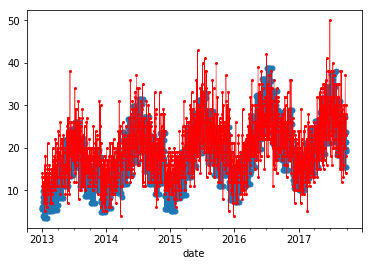

In [210]:
TDG[(TDG["item"] == 1) & (TDG["store"] == 1)].predicted.plot(marker="o", markersize = 5)
TDG[(TDG["item"] == 1) & (TDG["store"] == 1)].sales.plot(marker="o", color = "r", linewidth = 0.5, markersize = 2)

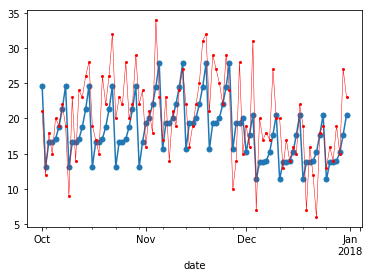

In [211]:
TEG[(TEG["item"] == 1) & (TEG["store"] == 1)].predicted.plot(marker="o", markersize = 5)
TEG[(TEG["item"] == 1) & (TEG["store"] == 1)].sales.plot(marker="o", color = "r", linewidth = 0.5, markersize = 2)

# Conclusions of the study

Linear regression of the overall data achieves similar results as the Gradient Boosting Regressor, around 18% test error. Applying regression to each individual case will show better accuracy for some item/store pairs, and reduced accuracy for other cases, the problem is that is does not take correlations of itens into account.

Since we are trying to predict store sales, which can be something extremely subjective, and there are several variables missing like weather, city, etc; one can expect a 18% accuracy to be reasonable in praxis.

Nonetheless, I would suggest trying other models that take correlations into account or apply a Bayesian Linear Regression with a hyperprior distribution.